In [ ]:
# Install necessary libraries for Gradio and Hugging Face transformers
!pip install gradio transformers joblib

# Install joblib for saving and loading models efficiently
!pip install joblib  # Install joblib to handle model serialization (saving and loading)

# Import necessary libraries and tools
from transformers import pipeline  # For zero-shot classification using Hugging Face's pipeline
import re  # For regular expression to extract the hour from the query
import joblib  # For loading LabelEncoders and scalers
import numpy as np  # For array operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For visualizing data
import seaborn as sns  # For creating count plots and visualizations
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping is used to stop training when the validation performance stops improving
from tensorflow.keras.layers import Dropout  # Import Dropout layer
import json  # Import the json module for pretty-printing data
from tensorflow.keras.models import load_model  # Import load_model from Keras
import gradio as gr
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and Keras for model creation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense  # For defining LSTM and Dense layers

# Sklearn for preprocessing and splitting data
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # For encoding labels and scaling features
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets


In [ ]:
# Load the dataset
df = pd.read_csv("/content/Riyadh_Metro_Synthetic_10k.csv")

In [ ]:
# Set the minimum count based on the 'High' congestion level (this will be used to balance the other categories)
min_count = df[df['Congestion_Level'] == 'High'].shape[0]

# Take the same number of samples from other categories (Low and Medium) to match the 'High' category
df_low = df[df['Congestion_Level'] == 'Low'].sample(n=min_count, random_state=42)
df_medium = df[df['Congestion_Level'] == 'Medium'].sample(n=min_count, random_state=42)
df_high = df[df['Congestion_Level'] == 'High']  # Keep all 'High' samples as they are

# Combine all the samples into a new balanced dataframe
df = pd.concat([df_low, df_medium, df_high]).sample(frac=1, random_state=42).reset_index(drop=True)

# Display the new distribution of the 'Congestion_Level' column
# The counts should now show balanced classes (Low, Medium, High)
print(df['Congestion_Level'].value_counts())


Congestion_Level
Medium    229
High      229
Low       229
Name: count, dtype: int64


In [ ]:
# Inspect the structure and basic properties of the dataset
# Display the shape of the dataset (number of rows and columns)
print("Dataset Shape:", df.shape)

# Print the data types of each column in the dataset
print("\nData Types:")
print(df.dtypes)

# Check for missing values in each column and display the count of missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Identify and count the number of duplicate rows in the dataset
print("\nDuplicate Rows:", df.duplicated().sum())

# Display the distribution of the target variable 'Congestion_Level' (i.e., how many instances of each class)
print("\nClass Distribution (Congestion_Level):")
print(df['Congestion_Level'].value_counts())

Dataset Shape: (687, 11)

Data Types:
Route_ID             object
Start_Station        object
End_Station          object
Hour                  int64
Weekday              object
Distance_km         float64
Travel_Time_mins    float64
Peak_Hour            object
Passenger_Demand      int64
Speed_kmph          float64
Congestion_Level     object
dtype: object

Missing Values:
Route_ID            0
Start_Station       0
End_Station         0
Hour                0
Weekday             0
Distance_km         0
Travel_Time_mins    0
Peak_Hour           0
Passenger_Demand    0
Speed_kmph          0
Congestion_Level    0
dtype: int64

Duplicate Rows: 0

Class Distribution (Congestion_Level):
Congestion_Level
Medium    229
High      229
Low       229
Name: count, dtype: int64


In [ ]:
# Display the first few rows of the dataset to get an overview of the data
df.head()

,Route_ID,Start_Station,End_Station,Hour,Weekday,Distance_km,Travel_Time_mins,Peak_Hour,Passenger_Demand,Speed_kmph,Congestion_Level
0,Blue_R3,Al Yarmouk,King Fahad Road,16,Friday,9.26,22.9,Yes,482,24.3,Medium
1,Yellow_R4,Al Batha,Al Aziziyah,7,Friday,16.32,36.7,Yes,864,26.7,High
2,Green_R2,Qasr Al Hokm,Al Yarmouk,7,Monday,3.62,5.6,Yes,467,38.9,Medium
3,Yellow_R4,Al Aziziyah,King Khalid International Airport,9,Thursday,16.72,34.5,Yes,572,29.1,Medium
4,Green_R2,Olaya Street,Al Murabba,12,Wednesday,2.17,4.3,No,444,30.1,Medium


In [ ]:
# Generate descriptive statistics for numerical columns in the dataset
print("\nNumerical Summary:")
print(df.describe())

# Display the number of unique values in key categorical columns
print("\nUnique values in categorical columns:")
# Number of unique routes
print("Route_ID:", df['Route_ID'].nunique())
# Number of unique starting stations
print("Start_Station:", df['Start_Station'].nunique())
# Number of unique ending stations
print("End_Station:", df['End_Station'].nunique())
# List all unique weekdays
print("Weekday:", df['Weekday'].unique())
# List all unique peak hours
print("Peak_Hour:", df['Peak_Hour'].unique())


Numerical Summary:
             Hour  Distance_km  Travel_Time_mins  Passenger_Demand  Speed_kmph
count  687.000000   687.000000        687.000000        687.000000  687.000000
mean    11.896652    13.687351         22.293595        581.780204   40.066958
std      6.320828     6.513471         12.926548        245.943515   11.233859
min      0.000000     2.020000          2.500000         50.000000   20.200000
25%      7.000000     8.335000         12.300000        395.000000   30.750000
50%     12.000000    13.840000         20.300000        565.000000   40.000000
75%     17.000000    18.970000         30.550000        825.000000   49.200000
max     23.000000    24.960000         66.900000       1191.000000   60.000000

Unique values in categorical columns:
Route_ID: 4
Start_Station: 15
End_Station: 15
Weekday: ['Friday' 'Monday' 'Thursday' 'Wednesday' 'Saturday' 'Sunday' 'Tuesday']
Peak_Hour: ['Yes' 'No']


<ipython-input-9-03e8008ff775>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Congestion_Level', data=df, palette='Set2')


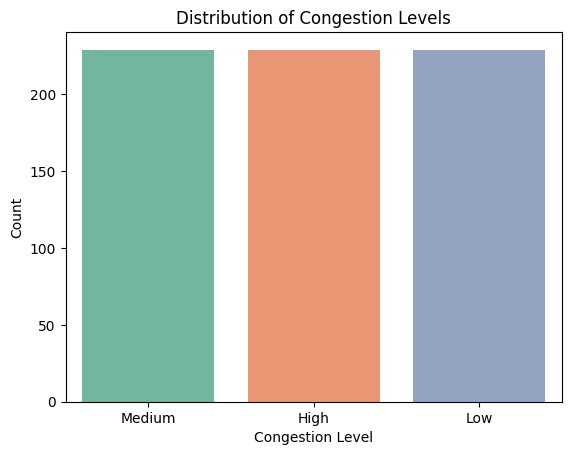

In [ ]:
# Create a countplot to visualize the distribution of 'Congestion_Level'
sns.countplot(x='Congestion_Level', data=df, palette='Set2')
plt.title("Distribution of Congestion Levels")  # Set the title of the plot
plt.xlabel("Congestion Level")  # Label the x-axis
plt.ylabel("Count")  # Label the y-axis
plt.show()  # Display the plot


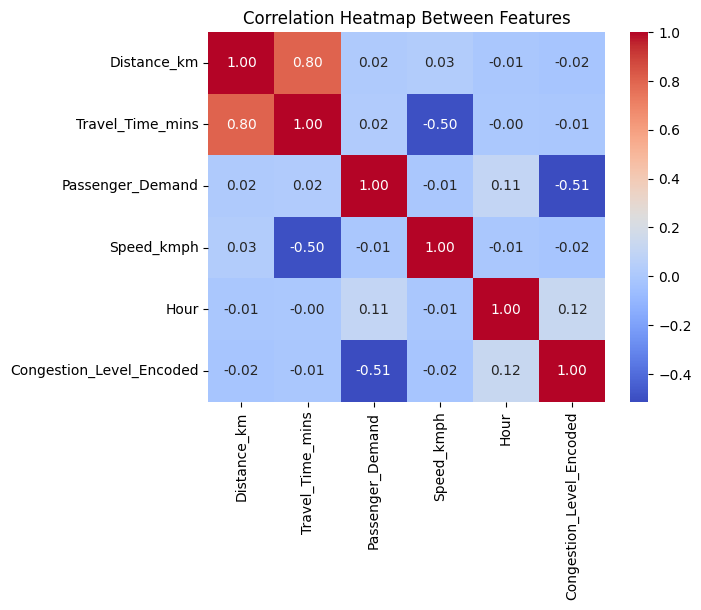

In [ ]:
# Create a copy of the original dataframe and encode the 'Congestion_Level' column as numeric values
df_encoded = df.copy()  # Create a copy of the original dataframe
df_encoded['Congestion_Level_Encoded'] = LabelEncoder().fit_transform(df_encoded['Congestion_Level'])  # Encode 'Congestion_Level'

# Generate a heatmap to visualize the correlation between selected numerical features
sns.heatmap(
    df_encoded[['Distance_km', 'Travel_Time_mins', 'Passenger_Demand', 'Speed_kmph', 'Hour', 'Congestion_Level_Encoded']].corr(),  # Compute correlations between the features
    annot=True,  # Annotate each cell with the correlation value
    fmt=".2f",  # Format the correlation values to 2 decimal places
    cmap="coolwarm"  # Set the color map to 'coolwarm' for better visual distinction
)

# Set the title of the heatmap
plt.title("Correlation Heatmap Between Features")
# Display the heatmap
plt.show()


<ipython-input-11-015e1d38abb9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Congestion_Level', y='Passenger_Demand', data=df, palette='Set3')  # Use seaborn to create the boxplot with a custom color palette


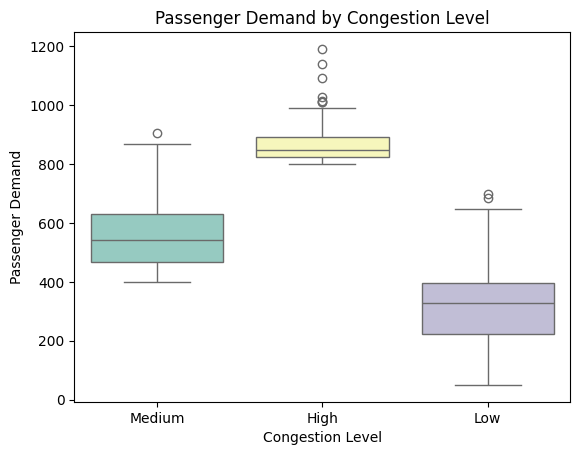

In [ ]:
# Create a boxplot to visualize the distribution of 'Passenger_Demand' across different 'Congestion_Level' categories
sns.boxplot(x='Congestion_Level', y='Passenger_Demand', data=df, palette='Set3')  # Use seaborn to create the boxplot with a custom color palette
# Set the title of the plot
plt.title("Passenger Demand by Congestion Level")
# Label the x-axis
plt.xlabel("Congestion Level")
# Label the y-axis
plt.ylabel("Passenger Demand")
# Display the plot
plt.show()

In [ ]:
# Encode categorical columns using LabelEncoder to convert text labels into numerical values

# Create label encoders for each categorical column
le_congestion = LabelEncoder()  # For encoding 'Congestion_Level'
le_peak = LabelEncoder()  # For encoding 'Peak_Hour'
le_route = LabelEncoder()  # For encoding 'Route_ID'
le_weekday = LabelEncoder()  # For encoding 'Weekday'
le_start = LabelEncoder()  # For encoding 'Start_Station'
le_end = LabelEncoder()  # For encoding 'End_Station'

# Apply the label encoders to the corresponding columns
df['Congestion_Level_Encoded'] = le_congestion.fit_transform(df['Congestion_Level'])  # Encode 'Congestion_Level'
df['Peak_Hour_Encoded']       = le_peak.fit_transform(df['Peak_Hour'])  # Encode 'Peak_Hour'
df['Route_ID_Encoded']        = le_route.fit_transform(df['Route_ID'])  # Encode 'Route_ID'
df['Weekday_Encoded']         = le_weekday.fit_transform(df['Weekday'])  # Encode 'Weekday'
df['Start_Station_Encoded']   = le_start.fit_transform(df['Start_Station'])  # Encode 'Start_Station'
df['End_Station_Encoded']     = le_end.fit_transform(df['End_Station'])  # Encode 'End_Station'

In [ ]:
# Normalize numerical features using MinMaxScaler to scale values between 0 and 1

# Create a MinMaxScaler instance to normalize the features
scaler = MinMaxScaler()

# List the numerical features to be normalized
numerical_features = [
    'Distance_km',  # Distance in kilometers
    'Travel_Time_mins',  # Travel time in minutes
    'Passenger_Demand',  # Passenger demand
    'Speed_kmph'  # Speed in kilometers per hour
]

# Apply the MinMaxScaler to the selected numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])  # Scale each numerical feature

In [ ]:
# Define the input features and target variable for the model

# List of selected features (input variables) to be used for prediction
selected_features = [
    'Distance_km',  # Distance in kilometers
    'Travel_Time_mins',  # Travel time in minutes
    'Passenger_Demand',  # Passenger demand
    'Speed_kmph',  # Speed in kilometers per hour
    'Hour',  # Hour of the day
    'Peak_Hour_Encoded',  # Encoded peak hour value
    'Weekday_Encoded',  # Encoded weekday value
    'Route_ID_Encoded',  # Encoded route ID
    'Start_Station_Encoded',  # Encoded start station
    'End_Station_Encoded'  # Encoded end station
]

# Define the target variable
target_column = 'Congestion_Level_Encoded'

# Separate the features (X) and the target variable (y)
X = df[selected_features]  # Input features
y = df[target_column]  # Target variable

In [ ]:
# Split the data into training and testing sets

# Use train_test_split to divide the data into training and testing sets
# 80% of the data will be used for training, and 20% will be used for testing
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Input features
    y,  # Target variable
    test_size=0.2,  # Set 20% of the data for testing
    random_state=42  # Set a random seed for reproducibility
)

In [ ]:
# Reshape the data for LSTM input format (3D array: samples, timesteps, features)

# Reshape the training data to have 3 dimensions: (samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train.values, axis=1)  # Add an extra dimension to the data (timesteps=1)

# Reshape the test data to have 3 dimensions: (samples, timesteps, features)
X_test_lstm  = np.expand_dims(X_test.values, axis=1)  # Add an extra dimension to the data (timesteps=1)

In [ ]:
# Compute class weights based on the target variable 'y_train'
# The 'balanced' method automatically adjusts the weight inversely proportional to class frequencies in the input data
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),  # Get unique classes in the target variable
                                     y=y_train)  # Pass the target variable (y_train)

# Convert the class weights into a dictionary for easy reference
class_weight_dict = dict(enumerate(class_weights))  # Mapping class index to the corresponding weight

# Print the computed class weights for each class
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(1.0223463687150838), 1: np.float64(0.9891891891891892), 2: np.float64(0.9891891891891892)}


In [ ]:
# Build the LSTM model
model = Sequential()

# LSTM layer with 64 units
# The input_shape should match the shape of your training data, where X_train_lstm is the training data
model.add(LSTM(units=64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))

# Add a Dropout layer to prevent overfitting
# Dropout will randomly set input units to 0 during training with the given rate (e.g., 0.2 means 20% of the inputs will be set to 0)
model.add(Dropout(0.2))  # You can adjust the dropout rate

# Fully connected hidden layer with 32 units and ReLU activation
model.add(Dense(units=32, activation='relu'))

# Output layer with 3 units for the 3 classes (High, Medium, Low) and softmax activation to get probabilities
model.add(Dense(units=3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model by specifying the loss function, optimizer, and evaluation metrics
# Loss function 'sparse_categorical_crossentropy' is used for multi-class classification problems
# 'adam' optimizer is used for efficient gradient-based optimization
# 'accuracy' is used as the evaluation metric to track model performance during training
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the LSTM model on the training data

# Use the fit method to train the model
# epochs specifies the number of times the model will iterate over the entire training dataset
# batch_size determines how many samples are processed together before updating the model weights
# validation_split reserves a portion of the training data for validation to monitor performance during training
# class_weight is used to handle class imbalances by assigning different weights to each class based on frequency

# Define early stopping to monitor validation loss and stop when it doesn't improve for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_lstm, y_train,  # Input training data and labels
          validation_data=(X_test_lstm, y_test),  # Validation data and labels
          epochs=15,  # The number of times the model will iterate over the entire training dataset
          batch_size=16,  # The number of samples processed together before model weight update
          class_weight=class_weight_dict,
          callbacks=[early_stopping])  # Adjust class weights to balance the impact of each class


Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3381 - loss: 1.1361 - val_accuracy: 0.4638 - val_loss: 1.0566
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4665 - loss: 1.0530 - val_accuracy: 0.6304 - val_loss: 0.9961
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5410 - loss: 1.0146 - val_accuracy: 0.6667 - val_loss: 0.9220
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5946 - loss: 0.9460 - val_accuracy: 0.7101 - val_loss: 0.8319
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6592 - loss: 0.8181 - val_accuracy: 0.6957 - val_loss: 0.7289
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6618 - loss: 0.7479 - val_accuracy: 0.7391 - val_loss: 0.6304
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6699 - loss: 0.6933 - val_accuracy: 0.6522 - val_loss: 0.6136
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6959 - loss: 0.6462 - val_accuracy: 0.7174 - v

In [ ]:
# Save the LabelEncoders and scaler using joblib for later use

# Save the LabelEncoder for 'Start_Station' to a file so it can be loaded later for inverse transformation or future encoding
joblib.dump(le_start, "station_encoder.pkl")  # Save the encoder for stations

# Save the LabelEncoder for 'Weekday' to a file
joblib.dump(le_weekday, "day_encoder.pkl")  # Save the encoder for weekdays

# Save the MinMaxScaler for later use
joblib.dump(scaler, "scaler.pkl")  # Save the scaler for normalizing numerical features

['scaler.pkl']

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8751 - loss: 0.4264
Test Accuracy: 0.8623188138008118
Test Loss: 0.43292465806007385


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict class probabilities
y_pred_probs = model.predict(X_test_lstm)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Print detailed report
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91        50
           1       0.86      0.95      0.90        44
           2       0.90      0.64      0.75        44

    accuracy                           0.86       138
   macro avg       0.87      0.86      0.85       138
weighted avg       0.87      0.86      0.85       138

Confusion Matrix:
[[49  0  1]
 [ 0 42  2]
 [ 9  7 28]]


In [ ]:
#  Distance, Travel Time, Demand, Speed, Hour, Peak, Weekday, Route, Start, End
new_data_low = np.array([[0.2, 0.1, 0.15, 0.4, 3, 0, 5, 1, 4, 8]])  # Example input data for the 'Low' congestion level
new_data_low = np.expand_dims(new_data_low, axis=1)  # Reshaping the input data to match the LSTM input format (samples, timesteps, features)

# Make prediction using the trained model
prediction = model.predict(new_data_low)  # Predict the congestion level based on the input data

# Get the predicted class (index of the highest probability)
predicted_class = np.argmax(prediction)  # Get the class with the highest probability

# Convert the predicted class index back to the original label (Low, Medium, High)
predicted_label = le_congestion.inverse_transform([predicted_class])  # Convert numerical label to actual congestion level

# Print the predicted congestion level
print("Predicted Congestion Level:", predicted_label[0])  # Output the predicted congestion level


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted Congestion Level: Low


In [ ]:
# new_data: Example input data representing the features (Distance, Travel Time, Demand, Speed, Hour, Peak, Weekday, Route, Start Station, End Station)
# These values are in the range expected by the model.
new_data = np.array([[0.6, 0.3, 0.7, 0.5, 18, 1, 4, 2, 7, 12]])  # Example input

# np.expand_dims: Adds an extra dimension to the input to match the expected shape for LSTM input (samples, timesteps, features)
new_data = np.expand_dims(new_data, axis=1)  # Add time step dimension for LSTM

# Make a prediction using the trained model
prediction = model.predict(new_data)  # Predict the congestion level based on the input data

# np.argmax: Get the index of the class with the highest probability (High=0, Medium=1, Low=2)
predicted_class = np.argmax(prediction)  # Get the predicted class with the highest probability

# le_congestion.inverse_transform: Convert the predicted class index back to the corresponding congestion level (Low, Medium, High)
predicted_label = le_congestion.inverse_transform([predicted_class])  # Convert numeric label to congestion level

# Output the predicted congestion level
print("Predicted Congestion Level:", predicted_label[0])  # Print the predicted congestion level


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Congestion Level: High


In [ ]:
# new_data_medium: Example input data for the 'Medium' congestion level
# This array contains the normalized feature values for Distance, Travel Time, Demand, Speed, Hour, Peak, Weekday, Route, Start, and End
new_data_medium = np.array([[0.4, 0.3, 0.5, 0.45, 13, 0, 2, 1, 5, 9]])  # Example input

# np.expand_dims: Adds an extra dimension to the input to match the expected shape for LSTM input (samples, timesteps, features)
new_data_medium = np.expand_dims(new_data_medium, axis=1)  # Reshape the input to 3D (samples, timesteps, features)

# Make a prediction using the trained model
prediction = model.predict(new_data_medium)  # Predict the congestion level based on the input data

# np.argmax: Get the index of the class with the highest probability (High=0, Medium=1, Low=2)
predicted_class = np.argmax(prediction)  # Get the class index with the highest probability

# le_congestion.inverse_transform: Convert the predicted class index back to the corresponding congestion level (Low, Medium, High)
predicted_label = le_congestion.inverse_transform([predicted_class])  # Convert numeric label to congestion level

# Output the predicted congestion level
print("Predicted Congestion Level:", predicted_label[0])  # Print the predicted congestion level


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Congestion Level: Medium


Encoding categorical columns using LabelEncoder
- Congestion_Level: High/Medium/Low → 0/1/2
- Peak_Hour: Yes/No → 1/0
- Route_ID: encoded to numbers (e.g., Red_R1 → 0)
- Weekday: Sunday to Saturday → 0 to 6
- Start_Station & End_Station: each station name encoded to a unique number


In [ ]:
# Save the trained model
model.save("lstm_model.h5")

# PRETRAINED MODEL
**Model Used:** facebook/bart-large-mnli

In [ ]:
# Load the classification model for zero-shot classification
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")  # Load pre-trained model for zero-shot classification

#  Define supporting lists for stations and weekdays
station_list = [
    "Al Batha", "Al Suwaidi", "Imam Muhammad Bin Saud University",
    "King Fahad Road", "Al Murabba", "King Khalid International Airport",
    "Qasr Al Hokm", "Prince Mohammed Bin Abdulaziz Street", "Olaya Street",
    "Salah Al Din", "Al Malaz", "Al Hayer", "King Abdullah Financial District",
    "Al Aziziyah", "Al Yarmouk"
]

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
#  Define the function that extracts information from the user's query
def extract_user_query_info(query):
    # Use the classifier to identify the best matching station from the list
    station_scores = classifier(query, station_list)
    best_station = station_scores["labels"][0] if station_scores["scores"][0] > 0.6 else None  # Get the best matching station with a confidence > 0.6

    # Use the classifier to identify the best matching weekday
    weekday_scores = classifier(query, weekdays)
    best_day = weekday_scores["labels"][0] if weekday_scores["scores"][0] > 0.6 else None  # Get the best matching weekday with a confidence > 0.6

    # Extract the hour from the query using regular expression (handles both AM and PM)
    hour_match = re.search(r'(\d{1,2})\s*(AM|PM)', query, re.IGNORECASE)
    if hour_match:
        hour = int(hour_match.group(1))  # Extract hour
        if "PM" in hour_match.group(2).upper() and hour != 12:  # Convert PM times to 24-hour format
            hour += 12
    else:
        hour = None  # If no hour is found, set it to None

    return {
        "Start_Station": best_station,  # Extracted station
        "Hour": hour,  # Extracted hour
        "Weekday": best_day  # Extracted weekday
    }

#  Test the extraction function with a sample query
query = "What is the congestion at Al Batha station on Monday at 8 AM?"  # Sample user query
features = extract_user_query_info(query)  # Extract features from the query

# Print the extracted information in a formatted JSON structure
print("📦 Extracted Info:\n", json.dumps(features, indent=2))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


📦 Extracted Info:
 {
  "Start_Station": "Al Batha",
  "Hour": 8,
  "Weekday": "Monday"
}


In [ ]:
# Load the pre-trained LSTM model
lstm_model = load_model("lstm_model.h5")  # Load the LSTM model

# Load the necessary preprocessing tools (scalers and encoders)
scaler = joblib.load("scaler.pkl")  # Load the scaler used for feature normalization
station_encoder = joblib.load("station_encoder.pkl")  # Load the LabelEncoder for stations
day_encoder = joblib.load("day_encoder.pkl")  # Load the LabelEncoder for weekdays
# Define the function for making predictions using the LSTM model
def predict_congestion(query):
    # Extract features from the user's query
    extracted = extract_user_query_info(query)

    # Check if any required data is missing
    if None in extracted.values():
        return "⚠️ Incomplete data, please rephrase your question."

    # Encode the extracted station and weekday
    station_encoded = station_encoder.transform([extracted["Start_Station"]])[0]
    day_encoded = day_encoder.transform([extracted["Weekday"]])[0]

    # Prepare dummy input for the model
    dummy_input = np.array([[0, 0, 0, 0]])  # Dummy data for unused features
    dummy_input = scaler.transform(dummy_input)

    # Construct the final input for the LSTM model
    X_input = np.array([[dummy_input[0][0], dummy_input[0][1], dummy_input[0][2], dummy_input[0][3],
                         extracted["Hour"], day_encoded, 0, 0, station_encoded, 0]])

    # Reshape the input to match the LSTM input format (samples, timesteps, features)
    X_input_lstm = np.expand_dims(X_input, axis=1)
    prediction = lstm_model.predict(X_input_lstm)

    # Get the predicted class and its associated label
    probabilities = prediction[0]
    labels = ["High", "Medium", "Low"]
    emojis = {"Low": "🟢", "Medium": "🟡", "High": "🔴"}
    predicted_class = np.argmax(probabilities)
    predicted_label = labels[predicted_class]

    # Build the final result string
    result = f"""
    🚉 Station: {extracted['Start_Station']}
    📅 Day: {extracted['Weekday']}
    🕗 Hour: {extracted['Hour']}:00

    🔮 Predicted Congestion: {emojis[predicted_label]} {predicted_label}
    -------------------------
    Probabilities:
    {emojis['High']} High: {probabilities[0]:.2%}
    {emojis['Medium']} Medium: {probabilities[1]:.2%}
    {emojis['Low']} Low: {probabilities[2]:.2%}
    """

    return result


# Let user enter a query
user_query = input("📝 Enter your query (e.g., What is the congestion at Al Batha station on Monday at 8 AM?")
result = predict_congestion(user_query)
print(result)

📝 Enter your query (e.g., What is the congestion at Al Batha station on Monday at 8 AM?What is the congestion at Al Batha station on Monday at 8 AM?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

    🚉 Station: Al Batha
    📅 Day: Monday
    🕗 Hour: 8:00

    🔮 Predicted Congestion: 🔴 High
    -------------------------
    Probabilities:
    🔴 High: 57.30%
    🟡 Medium: 5.71%
    🟢 Low: 36.98%
    


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Load models and encoders
lstm_model = load_model("lstm_model.h5")  # Load the pre-trained LSTM model
scaler = joblib.load("scaler.pkl")  # Load the scaler used for feature normalization
station_encoder = joblib.load("station_encoder.pkl")  # Load the LabelEncoder for stations
day_encoder = joblib.load("day_encoder.pkl")  # Load the LabelEncoder for weekdays
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")  # Load pre-trained model for zero-shot classification


# Create the Gradio interface
iface = gr.Interface(
    fn=predict_congestion,
    inputs=gr.Textbox(label="Enter your query (e.g., What is the congestion at Al Batha station on Monday at 8 AM?)"),
    outputs=gr.Textbox(label="Prediction Result"),
    title="📊Insiyab",
    description="Get accurate predictions on the congestion level at Riyadh metro stations based on the day, time, and station.",
)

# Launch the Gradio interface
iface.launch()


Device set to use cuda:0


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://951aa04490285b85d4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
